In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print(torch.__version__, torch.cuda.is_available())

1.10.2 False


torch.Size([90, 10, 1])
torch.Size([90, 1])
torch.Size([90, 10, 1])
torch.Size([90, 1])


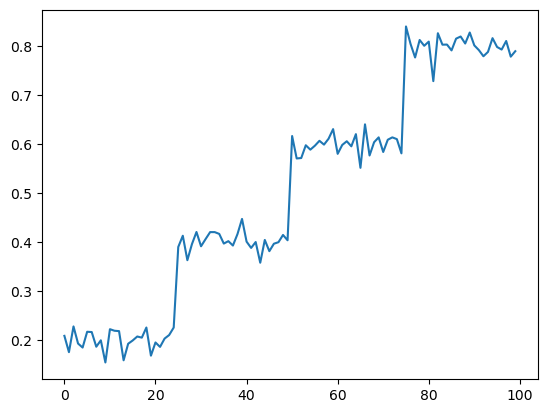

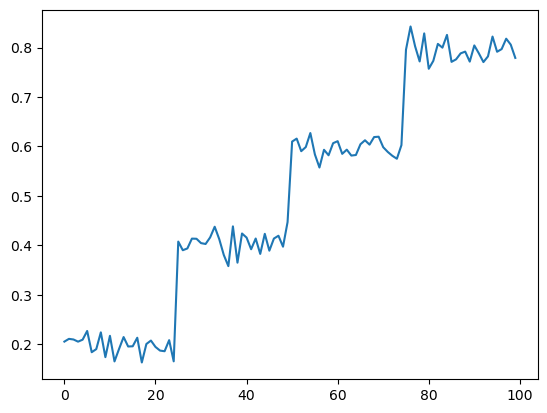

In [6]:
np.random.seed(1234)

# params
dataLength = 100
classNum = 4
classLength = int(dataLength/classNum)


# low data
x_0 = np.random.normal(loc=0.2, scale=0.02, size=classLength).reshape(-1, 1)
x_1 = np.random.normal(loc=0.4, scale=0.02, size=classLength).reshape(-1, 1)
x_2 = np.random.normal(loc=0.6, scale=0.02, size=classLength).reshape(-1, 1)
x_3 = np.random.normal(loc=0.8, scale=0.02, size=classLength).reshape(-1, 1)
train_x = np.concatenate([x_0, x_1, x_2, x_3])
plt.figure()
plt.plot(train_x)

x_0 = np.random.normal(loc=0.2, scale=0.02, size=classLength).reshape(-1, 1)
x_1 = np.random.normal(loc=0.4, scale=0.02, size=classLength).reshape(-1, 1)
x_2 = np.random.normal(loc=0.6, scale=0.02, size=classLength).reshape(-1, 1)
x_3 = np.random.normal(loc=0.8, scale=0.02, size=classLength).reshape(-1, 1)
test_x = np.concatenate([x_0, x_1, x_2, x_3])
plt.figure()
plt.plot(test_x)

label_0 = np.full(classLength, 0).reshape(-1, 1)
label_1 = np.full(classLength, 1).reshape(-1, 1)
label_2 = np.full(classLength, 2).reshape(-1, 1)
label_3 = np.full(classLength, 3).reshape(-1, 1)
train_label = np.concatenate([label_0, label_1, label_2, label_3])

label_0 = np.full(classLength, 0).reshape(-1, 1)
label_1 = np.full(classLength, 1).reshape(-1, 1)
label_2 = np.full(classLength, 2).reshape(-1, 1)
label_3 = np.full(classLength, 3).reshape(-1, 1)
test_label = np.concatenate([label_0, label_1, label_2, label_3])

# data = np.concatenate([x, label], axis= 1)

# make data set
def make_dataset(low_data, label, data_length):
    data, target = [], []
    for i in range(len(low_data)-data_length):
        data.append(low_data[i:i + data_length])
        target.append(label[i + data_length])
        
    re_data = np.array(data).reshape(len(data), data_length, low_data.shape[1])
    re_target = np.array(target).reshape(len(data), label.shape[1])

    return re_data, re_target

train_x, train_label = make_dataset(low_data=train_x, label = train_label, data_length = 10)
test_x, test_label = make_dataset(low_data=test_x, label = test_label, data_length = 10)

idx = np.arange(train_x.shape[0])
np.random.shuffle(idx)
train_x = train_x[idx, :, :].copy()
train_label = train_label[idx, :].copy()
test_x = test_x[idx, :, :].copy()
test_label = test_label[idx, :].copy()

train_x = torch.tensor(train_x, requires_grad=True, dtype = torch.float32)
train_label = torch.tensor(train_label, dtype = torch.long)
test_x = torch.tensor(test_x, requires_grad=True, dtype = torch.float32)
test_label = torch.tensor(test_label, dtype = torch.long)


print(train_x.shape)
print(train_label.shape)
print(test_x.shape)
print(test_label.shape)

In [8]:
class R_LLGMN_Pytorch(nn.Module):
    def __init__(self, dim, classNum, stateNum, componentNum, dataLength):
        #　変数
        self.dim = dim
        self.classNum = classNum                        # クラス数
        self.stateNum = stateNum                        # 状態数
        self.componentNum = componentNum                # コンポーネント数
        self.dataLength = dataLength                             # 時系列長
        self.logSize = int(1 + dim * (dim + 3) / 2)     # 非線形変換後のベクトル数
        # 各層の初期化
        self.in1 = torch.ones((self.dataLength, self.logSize), dtype = torch.float32)
        self.out1 = torch.zeros((self.dataLength, self.logSize), dtype = torch.float32)
        self.in2 = torch.zeros((self.dataLength, self.classNum, self.stateNum, self.stateNum, self.componentNum), dtype = torch.float32)
        self.out2 = torch.zeros((self.dataLength, self.classNum, self.stateNum, self.stateNum, self.componentNum), dtype = torch.float32)
        self.in3 = torch.zeros((self.dataLength, self.classNum, self.stateNum, self.stateNum), dtype = torch.float32)
        self.out3 = torch.zeros((self.dataLength, self.classNum, self.stateNum, self.stateNum), dtype = torch.float32)
        self.in4 = torch.zeros((self.dataLength, self.classNum, self.stateNum), dtype = torch.float32)
        self.out4 = torch.zeros((self.dataLength, self.classNum, self.stateNum), dtype = torch.float32)
        self.in5 = torch.zeros((self.dataLength, self.classNum), dtype = torch.float32)
        self.out5 = torch.zeros((self.dataLength, self.classNum), dtype = torch.float32)
        
        super(R_LLGMN_Pytorch, self).__init__()
        # パラメータ
        self.weight = nn.Parameter(0.01 * torch.randn((self.classNum, self.stateNum, self.stateNum, self.componentNum, self.logSize), dtype=torch.float32))
      

    # 順方向
    def forward(self, X):
        rho = 1e-5
        
        for t in range(self.dataLength):
            
            # ----第1層----
            x = X[t].reshape(dim, 1)
            a = x @ x.T
            
            # 1次の項
            for i in range(self.dim):
                self.in1[t][i+1] = X[t][i]
            # 2次の項
            for i in range(self.logSize - self.dim - 1):
                self.in1[t][i+self.dim+1] = a[np.triu_indices(self.dim)][i]
            self.out1[t] = self.in1[t]
            # ----第1層----
            
            for c in range(self.classNum):
                for k1 in range(self.stateNum):
                    for k in range(self.stateNum):
                        for m in range(self.componentNum):
                            # ----第2層----
                            self.in2[t][c][k1][k][m] = torch.sum(self.weight[c][k1][k][m].clone() * self.out1[t].clone())
                            self.out2[t][c][k1][k][m] = torch.exp(self.in2[t][c][k1][k][m].clone())
                            # ----第2層----

                        # ----第3層----
                        self.in3[t][c][k1][k] = torch.sum(self.out2[t][c][k1][k].clone())
                        if t == 0:
                            self.out3[t] = self.in3[t].clone()
                        else:
                            self.out3[t][c][k1][k] = self.out4[t-1][c][k1].clone() * self.in3[t][c][k1][k].clone()
                        # ----第3層----
                    
                    # ----第4層----
                    self.in4[t][c][k1] = torch.sum(self.out3[t][c][k1].clone())
                    
            F_NN = torch.sum(self.in4[t].clone())
            
            if F_NN != 0:
                self.out4[t] = self.in4[t].clone() / F_NN
            else: # エラー回避
                self.out4[t] = self.in4[t].clone() / rho
            # ----第4層----
            
            # ----第5層----
            for c in range(self.classNum):
                self.in5[t][c] = torch.sum(self.out4[t][c].clone())
            
            self.in5[t] = torch.sum(self.out4[t].clone(), axis=1)
            
            self.out5[t] = self.in5[t].clone()
            # ----第5層----
            y = self.out5[t].clone()
            return y


dim = 1
classNum = 4
stateNum = 2
componentNum = 2
dataLength = 10

model = R_LLGMN_Pytorch(dim, classNum, stateNum, componentNum, dataLength)
print(model)

R_LLGMN_Pytorch()


time:0, loss:1.385516881942749
time:1, loss:1.387868046760559
time:2, loss:1.3939554691314697
time:3, loss:1.3901803493499756
time:4, loss:1.3856425285339355
time:5, loss:1.3796164989471436
time:6, loss:1.3800530433654785
time:7, loss:1.3723174333572388
time:8, loss:1.3833863735198975
time:9, loss:1.3797134160995483
time:10, loss:1.3823846578598022
time:11, loss:1.4122915267944336
time:12, loss:1.3466806411743164
time:13, loss:1.3793696165084839
time:14, loss:1.379482626914978
time:15, loss:1.425174593925476
time:16, loss:1.4225115776062012
time:17, loss:1.3813079595565796
time:18, loss:1.3787493705749512
time:19, loss:1.423620343208313
time:20, loss:1.380753517150879
time:21, loss:1.3437464237213135
time:22, loss:1.3297430276870728
time:23, loss:1.3823535442352295
time:24, loss:1.3284556865692139
time:25, loss:1.3779691457748413
time:26, loss:1.37715482711792
time:27, loss:1.3367681503295898
time:28, loss:1.428515911102295
time:29, loss:1.41988205909729
time:30, loss:1.419478774070739

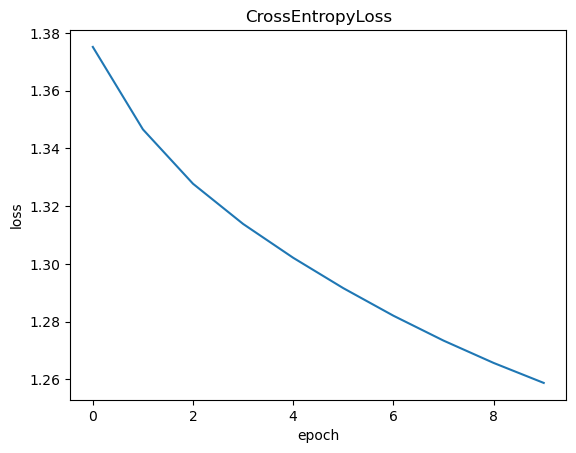

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_record = []
epochs = 10

torch.autograd.set_detect_anomaly(True)
for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    for j, (X, label) in enumerate(zip(train_x, train_label)):
        y = model(X).view(-1, classNum)
        loss = loss_function(y, label)
        print("time:{}, loss:{}".format(j, loss))
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    running_loss /= j+1
    loss_record.append(running_loss)
    print("epoch:", epoch, "\t", "loss:", running_loss)
print("done.")

plt.figure()
plt.plot(loss_record)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("CrossEntropyLoss")
plt.savefig("classNum=4_dataLength=10/RLL_loss.png")

In [10]:
import warnings
warnings.simplefilter('ignore')

predict_list = np.ones(len(test_label))
answer_list = np.ones(len(test_label))
predict_df = pd.DataFrame(columns=["answer", "predict", "exact"])
model.eval()
with torch.no_grad():
    for j, (X, label) in enumerate(zip(test_x, test_label)):
        y = model(X)
        predict = torch.argmax(y).to("cpu")
        predict = np.array(predict)
        predict_list[j] = predict 
        answer = np.array(label.item())
        answer_list[j] = answer
        exact = "O" if predict.item() == answer.item() else "X"
        s = pd.Series([answer, predict, exact], index=predict_df.columns)
        predict_df = predict_df.append(s, ignore_index=True)

print(predict_df.value_counts("exact"))
print(predict_df)

exact
O    50
X    40
dtype: int64
   answer predict exact
0       0       1     X
1       2       3     X
2       3       3     O
3       3       3     O
4       3       3     O
..    ...     ...   ...
85      2       1     X
86      2       1     X
87      1       1     O
88      2       3     X
89      2       1     X

[90 rows x 3 columns]


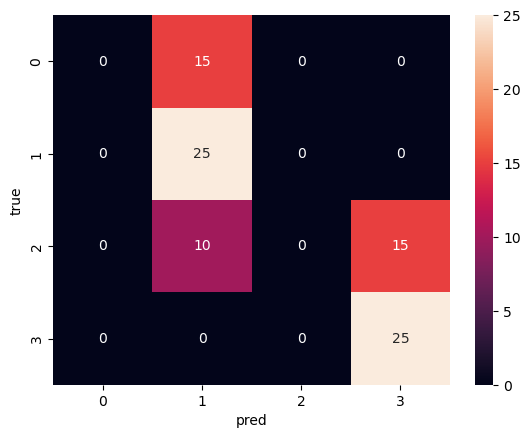

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

report = classification_report(answer_list, predict_list,output_dict= True)
pd_report = pd.DataFrame(report).transpose()
pd_report.to_csv("classNum=4_dataLength=10/RLL_report.csv")

matrix = confusion_matrix(answer_list, predict_list)
sns.heatmap(matrix, annot=True)
plt.xlabel("pred")
plt.ylabel('true')
plt.savefig("classNum=4_dataLength=10/RLL_confusion_matrix.png")

In [7]:
# # label_0
# TP0 = 0
# FN0 = 0
# FP0 = 0
# TN0 = 0
# for ans, pred in zip(predict_df["answer"], predict_df["predict"]):
#     if (ans == 0 and pred == 0):
#         TP0 += 1
#     elif (ans == 0 and pred != 0):
#         FN0 += 1
#     elif (ans != 1 and pred == 0):
#         FP0 += 1
#     elif (ans != 0 and pred != 0):
#         TN0 += 1

        
# label_0 = 0     
# all_0 = (predict_df["answer"] == 0).sum()

# acc_0 = (TP0+TN0) / (TP0+TN0+FP0+FN0)

# recall_0 = TP0 / (TP0+FN0)

# pre_0 = TP0 / (TP0+FP0)

# F_0 = (2*recall_0*pre_0) / (recall_0+pre_0)

# score_0 = np.array([label_0, all_0, acc_0, recall_0, pre_0, F_0])
# print(score_0)



# # label_1
# TP1 = 0
# FN1 = 0
# FP1 = 0
# TN1 = 0
# for ans, pred in zip(predict_df["answer"], predict_df["predict"]):
#     if (ans == 1 and pred == 1):
#         TP1 += 1
#     elif (ans == 1 and pred != 1):
#         FN1 += 1
#     elif (ans != 1 and pred == 1):
#         FP1 += 1
#     elif (ans != 1 and pred != 1):
#         TN1 += 1

        
# label_1 = 1    
# all_1 = (predict_df["answer"] == 1).sum()

# acc_1 = (TP1+TN1) / (TP1+TN1+FP1+FN1)

# recall_1 = TP1 / (TP1+FN1)

# pre_1 = TP1 / (TP1+FP1)

# F_1 = (2*recall_1*pre_1) / (recall_1+pre_1)

# score_1 = np.array([label_1, all_1, acc_1, recall_1, pre_1, F_1])
# print(score_1)



# # # label_2
# TP2 = 0
# FN2 = 0
# FP2 = 0
# TN2 = 0
# for ans, pred in zip(predict_df["answer"], predict_df["predict"]):
#     if (ans == 2 and pred == 2):
#         TP2 += 1
#     elif (ans == 2 and pred != 2):
#         FN2 += 1
#     elif (ans != 2 and pred == 2):
#         FP2 += 1
#     elif (ans != 2 and pred != 2):
#         TN2 += 1

        
# label_2 = 2     
# all_2 = (predict_df["answer"] == 2).sum()

# acc_2 = (TP2+TN2) / (TP2+TN2+FP2+FN2)

# recall_2 = TP2 / (TP2+FN2)

# pre_2 = TP2 / (TP2+FP2)

# F_2 = (2*recall_2*pre_2) / (recall_2+pre_2)

# score_2 = np.array([label_2, all_2, acc_2, recall_2, pre_2, F_2])
# print(score_2)


# # # label_3
# TP3 = 0
# FN3 = 0
# FP3 = 0
# TN3 = 0
# for ans, pred in zip(predict_df["answer"], predict_df["predict"]):
#     if (ans == 3 and pred == 3):
#         TP3 += 1
#     elif (ans == 3 and pred != 3):
#         FN3 += 1
#     elif (ans != 3 and pred == 3):
#         FP3 += 1
#     elif (ans != 3 and pred != 3):
#         TN3 += 1

        
# label_3 = 3    
# all_3 = (predict_df["answer"] == 3).sum()

# acc_3 = (TP3+TN3) / (TP3+TN3+FP3+FN3)

# recall_3 = TP3 / (TP3+FN3)

# pre_3 = TP3 / (TP3+FP3)

# F_3 = (2*recall_3*pre_3) / (recall_3+pre_3)

# score_3 = np.array([label_3, all_3, acc_3, recall_3, pre_3, F_3])
# print(score_3)

# score_df = pd.DataFrame(np.vstack((score_0, score_1)),
#                        columns=["label", "all", "accuracy", "recall", "precision", "F-Score"])
# print(score_df)